# Introduction to Data Science – Lecture 12 – APIs
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

In this lecture we will explore how we can extract data from web-APIs. The first part of this tutorial is based on [this blog](https://www.dataquest.io/blog/python-api-tutorial/).

API stands for Application Programming Interface. It is supposed to be a **well defined interface** for consuming data (in contrast to web-scraping), or, more generally, for the **interaction with a remote program** on a server. APIs aren't only generated so that you can read data; they're often designed so that you could write custom software to interact with the API. You could, for example, write your own twitter client! 

APIs are usually well documented, as the organization that provides APIs wants you to use them. 

Here are a couple of examples of sites that have documented APIs:

 * [StackExchange](https://api.stackexchange.com/docs)  
 * [Twitter](https://dev.twitter.com/rest/public)
 * [Facebook](https://developers.facebook.com/docs/graph-api)
 * [KEGG](http://www.genome.jp/kegg/rest/keggapi.html) 
 * [Google Maps](https://developers.google.com/maps/) 
 * and many many more. 
 
Most APIs require some form of authentication and have rules on what you're allowed to do and what not. Follow those rules, or you will be blocked faster than you can say `GET`. 
 
An API works a lot like working with a website, but instead of a human in front of the screen, it's computers talking to each other. 

We'll be using the dominant form of APIs on the web: REST (REpresentational State Transfer). REST APIs use an [URI](https://en.wikipedia.org/wiki/Uniform_Resource_Identifier) (a Uniform Resource Identifier; URLs are one specific form of URIs) to specify what you want to do with and API.

All API methods in REST are relative to a base URL. E.g., for twitter this would be
```
https://api.twitter.com/1.1/
```

A query would look like this: 

```
https://api.twitter.com/1.1/search/tweets.json?q=%40twitterapi
```

REST APIs can return data in different forms, the most common ones are JSON and XML, and of those two, JSON is now dominant. 

JSON stands for JavaScript Object Notation, and is a pretty convenient format, as we'll see. 
 

Let's start with a very simple example, retrieving the current position of the ISS. We will be using the [requests library](http://www.python-requests.org/en/latest/), which will handle our communication with the server.

In [1]:
import requests 
# Make a get request to get the latest position of the international space station from the opennotify api.
response = requests.get("http://api.open-notify.org/iss-now.json")

response

<Response [200]>

That looks good, we've received a response and it has status 200. What does the 200 mean? It's a status code - you've probably seen the "Error 404" on the internet. 

Here are a couple of codes:

 * **200** – everything went okay, and the result has been returned (if any)
 * **301** – the server is redirecting you to a different endpoint. This can happen when a company switches domain names, or an endpoint name is changed.
 * **401** – the server thinks you’re not authenticated. This happens when you don’t send the right credentials to access an API (we’ll talk about authentication later).
 * **400** – the server thinks you made a bad request. This can happen when you don’t send along the right data, among other things.
 * **403** – the resource you’re trying to access is forbidden – you don’t have the right permissions to see it.
 * **404** – the resource you tried to access wasn’t found on the server.

Let's try to get a response with a wrong URL:

In [2]:
response_failed = requests.get("http://api.open-notify.org/iss")

response_failed

<Response [400]>

We used the get methods to put in a GET request. There are four different types of requests: 

![Request types](requests.png)
[Source](https://en.wikipedia.org/wiki/Representational_state_transfer)

Let's look at the payload of our previous, successful response:

In [3]:
response.content

b'{"iss_position": {"longitude": "106.9544", "latitude": "-2.2609"}, "timestamp": 1550187708, "message": "success"}'

We can already see that this is JSON (though it is stored a `bytes` object), but we can check formally:

In [4]:
response.headers['content-type']

'application/json'

We can decode this byte object, then the JSON will be readable. 

In [5]:
response_j = response.content.decode("utf-8")
print(response_j)

{"iss_position": {"longitude": "106.9544", "latitude": "-2.2609"}, "timestamp": 1550187708, "message": "success"}


Let's take a look at the JSON here:

```JSON
{
  "iss_position": {
    "latitude": -30.005751854107206, 
    "longitude": -104.20085371352678
  }, 
  "message": "success", 
  "timestamp": 1475240215
}
```

This looks a lot like a dictionary! We have key-value pairs. 

We can use the [json library](https://docs.python.org/3/library/json.html) to convert JSON into objects:

In [6]:
import json
response_d = json.loads(response_j)
print(type(response_d))
print(response_d)
response_d["iss_position"]

<class 'dict'>
{'iss_position': {'longitude': '106.9544', 'latitude': '-2.2609'}, 'timestamp': 1550187708, 'message': 'success'}


{'longitude': '106.9544', 'latitude': '-2.2609'}

Or, not surprisingly, pandas can also load a json object:

In [7]:
import pandas as pd 

df = pd.read_json(response_j)
df

,iss_position,timestamp,message
latitude,-2.2609,2019-02-14 23:41:48,success
longitude,106.9544,2019-02-14 23:41:48,success


This isn't quite what we want - we probably want one row per timestamp and longitude and latitude as columns:

In [8]:
def flatten(response_d):
    response_d["latitude"] = response_d["iss_position"]["latitude"]
    response_d["longitude"] = response_d["iss_position"]["longitude"]
    del(response_d["iss_position"])
    return response_d
flatten(response_d)

{'timestamp': 1550187708,
 'message': 'success',
 'latitude': '-2.2609',
 'longitude': '106.9544'}

That looks better. Let's get a couple of positions of the ISS over time and save it as an array:

In [9]:
import time

def pull_position():
    """Retreives the position of the ISS and returns it as a flat dictionary"""
    response = requests.get("http://api.open-notify.org/iss-now.json")
    response_j = response.content.decode("utf-8")
    response_d = json.loads(response_j)
    flat_response = flatten(response_d)
    return flat_response    

iss_position = []
    
# calls pull_position 10 times with 3 seconds break
for i in range(10):
    flat_response = pull_position()
    iss_position.append(flat_response)
    print(flat_response)
    time.sleep(3)
    
len(iss_position)

{'timestamp': 1550187874, 'message': 'success', 'latitude': '6.1888', 'longitude': '112.9691'}
{'timestamp': 1550187877, 'message': 'success', 'latitude': '6.3665', 'longitude': '113.0973'}
{'timestamp': 1550187880, 'message': 'success', 'latitude': '6.5187', 'longitude': '113.2072'}
{'timestamp': 1550187883, 'message': 'success', 'latitude': '6.6709', 'longitude': '113.3171'}
{'timestamp': 1550187886, 'message': 'success', 'latitude': '6.8231', 'longitude': '113.4271'}
{'timestamp': 1550187890, 'message': 'success', 'latitude': '7.0008', 'longitude': '113.5557'}
{'timestamp': 1550187893, 'message': 'success', 'latitude': '7.1530', 'longitude': '113.6660'}
{'timestamp': 1550187896, 'message': 'success', 'latitude': '7.3051', 'longitude': '113.7763'}
{'timestamp': 1550187899, 'message': 'success', 'latitude': '7.4572', 'longitude': '113.8868'}
{'timestamp': 1550187902, 'message': 'success', 'latitude': '7.6093', 'longitude': '113.9972'}


10

Now we can convert this into a nice dataframe:

In [10]:
iss_position_df = pd.DataFrame(iss_position)
iss_position_df['timestamp']  = pd.to_datetime(iss_position_df['timestamp'], unit="s")

iss_position_df = iss_position_df.set_index(pd.DatetimeIndex(iss_position_df['timestamp']))
iss_position_df["latitude"] = iss_position_df["latitude"].map(float)
iss_position_df["longitude"] = iss_position_df["longitude"].map(float)
iss_position_df

,latitude,longitude,message,timestamp
timestamp,,,,
2019-02-14 23:44:34,6.1888,112.9691,success,2019-02-14 23:44:34
2019-02-14 23:44:37,6.3665,113.0973,success,2019-02-14 23:44:37
2019-02-14 23:44:40,6.5187,113.2072,success,2019-02-14 23:44:40
2019-02-14 23:44:43,6.6709,113.3171,success,2019-02-14 23:44:43
2019-02-14 23:44:46,6.8231,113.4271,success,2019-02-14 23:44:46
2019-02-14 23:44:50,7.0008,113.5557,success,2019-02-14 23:44:50
2019-02-14 23:44:53,7.1530,113.6660,success,2019-02-14 23:44:53
2019-02-14 23:44:56,7.3051,113.7763,success,2019-02-14 23:44:56
2019-02-14 23:44:59,7.4572,113.8868,success,2019-02-14 23:44:59


Let's see how the ISS moves

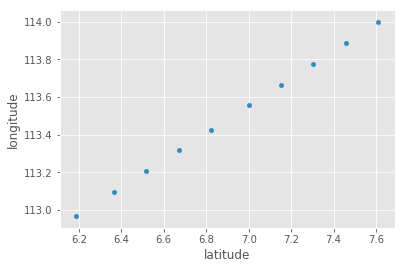

In [11]:
import matplotlib.pyplot as plt
# This next line tells jupyter to render the images inline
%matplotlib inline
plt.style.use('ggplot')
iss_position_df.plot(kind="scatter", x="latitude", y="longitude")

### Querying with Parameters

Requests can be parametrized. You can search for tweets of a specific user, for example, or [retrieve the time the ISS is over SLC](http://open-notify.org/Open-Notify-API/ISS-Pass-Times/)!

The way to query with a get request for the ISS is this:

`http://api.open-notify.org/iss-pass.json?lat=40.758701&lon=-111.876183`

We, of course, could generate that URL ourselves, but the requests library is helpful here. Since JSON is similar to dictionaries, the requests library takes dictionaries for parameters.

In [12]:
url = "http://api.open-notify.org/iss-pass.json"
coordinates = {"lat": 40.758701, "lon": -111.876183, "n":5}

r = requests.get(url, params=coordinates)
data = r.json()
data

{'message': 'success',
 'request': {'altitude': 100,
  'datetime': 1550187979,
  'latitude': 40.758701,
  'longitude': -111.876183,
  'passes': 5},
 'response': [{'duration': 621, 'risetime': 1550189446},
  {'duration': 207, 'risetime': 1550195394},
  {'duration': 489, 'risetime': 1550243754},
  {'duration': 640, 'risetime': 1550249439},
  {'duration': 592, 'risetime': 1550255277}]}

In [13]:
timestamp = data["response"][0]["risetime"]
pd.to_datetime(timestamp,  unit="s")

Timestamp('2019-02-15 00:10:46')

So, the ISS will be above SLC tonight!

### Exercise: How many Astronauts? 

Use the [Open Notify API](http://open-notify.org/Open-Notify-API/People-In-Space/) to find out how many people are in space right now.

## Libraries and Authentication

While we now have the skills to directly talk to an API, it's sometimes a little tedious. Popular APIs often have existing Python libraries that wrap around them. [Here](https://github.com/realpython/list-of-python-api-wrappers) is a long list of wrappers! 

Now we'll explore the Twitter API using the [twython library](https://github.com/ryanmcgrath/twython). Check out the [documentation](https://twython.readthedocs.io/en/latest/).

Unfortunately, most professional APIs will require you to authenticate and will limit you in what you can do – mostly they limit how much data you can retreive at a certain time. To run the following code, you'll have to put in your own credentials (sorry – I can't share mine). 

Install twython:
`pip install twython`

* Go to https://apps.twitter.com/ and create a new app
* Save your consumer key and consumer secret in a file `credentials.py` in the format:
```python
CONSUMER_KEY = "KEY"
CONSUMER_SECRET = "KEY"
```

But before we get started, let's check out what [a tweet looks like](https://dev.twitter.com/overview/api/tweets):

```JSON
{'contributors': None,
  'coordinates': None,
  'created_at': 'Fri Sep 30 18:37:48 +0000 2016',
  'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
  'favorite_count': 2960,
  'favorited': False,
  'geo': None,
  'id': 781926033159249920,
  'id_str': '781926033159249920',
  'in_reply_to_screen_name': None,
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'is_quote_status': False,
  'lang': 'en',
  'place': None,
  'retweet_count': 1283,
  'retweeted': False,
  'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
  'text': "For those few people knocking me for tweeting at three o'clock in the morning, at least you know I will be there, awake, to answer the call!",
  'truncated': False,
  'user': {'contributors_enabled': False,
   'created_at': 'Wed Mar 18 13:46:38 +0000 2009',
   'default_profile': False,
   'default_profile_image': False,
   'description': '',
   'entities': {'description': {'urls': []},
    'url': {'urls': [{'display_url': 'DonaldJTrump.com',
       'expanded_url': 'http://www.DonaldJTrump.com',
       'indices': [0, 23],
       'url': 'https://t.co/mZB2hymxC9'}]}},
   'favourites_count': 39,
   'follow_request_sent': None,
   'followers_count': 11929387,
   'following': None,
   'friends_count': 41,
   'geo_enabled': True,
   'has_extended_profile': False,
   'id': 25073877,
   'id_str': '25073877',
   'is_translation_enabled': True,
   'is_translator': False,
   'lang': 'en',
   'listed_count': 39225,
   'location': 'New York, NY',
   'name': 'Donald J. Trump',
   'notifications': None,
   'profile_background_color': '6D5C18',
   'profile_background_image_url': 'http://pbs.twimg.com/profile_background_images/530021613/trump_scotland__43_of_70_cc.jpg',
   'profile_background_image_url_https': 'https://pbs.twimg.com/profile_background_images/530021613/trump_scotland__43_of_70_cc.jpg',
   'profile_background_tile': True,
   'profile_banner_url': 'https://pbs.twimg.com/profile_banners/25073877/1468988952',
   'profile_image_url': 'http://pbs.twimg.com/profile_images/1980294624/DJT_Headshot_V2_normal.jpg',
   'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1980294624/DJT_Headshot_V2_normal.jpg',
   'profile_link_color': '0D5B73',
   'profile_sidebar_border_color': 'BDDCAD',
   'profile_sidebar_fill_color': 'C5CEC0',
   'profile_text_color': '333333',
   'profile_use_background_image': True,
   'protected': False,
   'screen_name': 'realDonaldTrump',
   'statuses_count': 33344,
   'time_zone': 'Eastern Time (US & Canada)',
   'url': 'https://t.co/mZB2hymxC9',
   'utc_offset': -14400,
   'verified': True}
```


In [16]:
from twython import Twython
# credentials is a local file with your own credentials. It defines CONSUMER_KEY and CONSUMER_SECRET
# you will have to load your own credentials here.
from credentials import * 
twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET)

Here, we have created the Twython library object and authenticated against our user.

Now let's search for a hashtag:

In [17]:
tag = "#resist"
result = twitter.search(q=tag, tweet_mode="extended")
result

{'statuses': [{'created_at': 'Thu Feb 14 23:51:20 +0000 2019',
   'id': 1096195214098743302,
   'id_str': '1096195214098743302',
   'full_text': 'Why do people choose nonviolence? Is nonviolence the same as pacifism? When are violent factions successful? We discuss these questions and more with RiveraSunAuthor. \n@kbzeese @MFlowers8 https://t.co/6v64pU2p8J #Resist https://t.co/9r4vawBsHd',
   'truncated': False,
   'display_text_range': [0, 219],
   'entities': {'hashtags': [{'text': 'Resist', 'indices': [212, 219]}],
    'symbols': [],
    'user_mentions': [{'screen_name': 'KBZeese',
      'name': 'Kevin Zeese',
      'id': 220727844,
      'id_str': '220727844',
      'indices': [168, 176]},
     {'screen_name': 'MFlowers8',
      'name': 'Margaret Flowers',
      'id': 828035485,
      'id_str': '828035485',
      'indices': [177, 187]}],
    'urls': [{'url': 'https://t.co/6v64pU2p8J',
      'expanded_url': 'https://popularresistance.org/movement-strategy-for-our-times/',
      'dis

The result is an array of tweets, we can look at specific text:

In [18]:
result["statuses"][0]["full_text"]

'Why do people choose nonviolence? Is nonviolence the same as pacifism? When are violent factions successful? We discuss these questions and more with RiveraSunAuthor. \n@kbzeese @MFlowers8 https://t.co/6v64pU2p8J #Resist https://t.co/9r4vawBsHd'

Or print all the tweets:

In [19]:
for status in result["statuses"]:
    print(status["full_text"])
    print("----")

Why do people choose nonviolence? Is nonviolence the same as pacifism? When are violent factions successful? We discuss these questions and more with RiveraSunAuthor. 
@kbzeese @MFlowers8 https://t.co/6v64pU2p8J #Resist https://t.co/9r4vawBsHd
----
Sketch of the day time lapse.  #protestwithart #Resist #Politicalcartoons #politicalcomics #Comics  #Trump #dumptrump #DonaldTrumpcartoons #resistDonaldTrump
#TrumpMeme #impechtrump 
#Trumplife  #sketchoftheday #notmypresident  #garbagepresident  #lockhimup #treaonustrump https://t.co/qhkCQzuNz7
----
It is very clear, @senatemajldr , like @POTUS only believes in #ExecutiveOverreach when the President was Black or #BarackObama . #Clarification #Resist the crazy https://t.co/CINJB1wlaG
----
RT @flowingfire: What is the United States' most significant national emergency?

Re-Tweet for a wider sampling.
#ClimateChange #Guns #Impe…
----
RT @TrumperSeaney: L&amp;G LET ME TRANSLATE THIS STORY BELOW: THE #Mueller REPORT HAS NOTHING ABOUT #TrumpRussi

We can also search for tweets based on usernames:

In [20]:
result = twitter.search(q="@realDonaldTrump",  tweet_mode="extended")
for status in result["statuses"]:
    print(status["full_text"])
    print("----")

Congrats @realDonaldTrump for being our first obese president since Taft
----
RT @T_S_P_O_O_K_Y: With McCabe's admissions today regarding his work organizing a "coup" against @realDonaldTrump it's a good time to revie…
----
RT @Jali_Cat: @IlhanMN @realDonaldTrump You are such a horrible person @IlhanMN @Ilhan. You truly are.

@realDonaldTrump has been on this e…
----
@BrianKarem @realDonaldTrump Mexico: "The pesos are in the mail!"
----
RT @Don_Vito_08: Trump approval soars to 52%
#MAGA2020 
 https://t.co/3WVNc0yEpZ via @realDonaldTrump https://t.co/OlIc7nYQdq
----
RT @JohnFotland: Hey @realDonaldTrump   explain this one, no don't, let the courts figure this out. https://t.co/PbxpryTkqR
----
RT @SpeakerPelosi: Declaring a national emergency would be a lawless act, a gross abuse of the power of the presidency and a desperate atte…
----
@realDonaldTrump Donald Trump was named as a co-conspirator in a federal crime entered into judgment in the Southern District of NY in a plea deal accept

This returns all tweets that are mentioning a username. We can also explicitly get the tweets of a person. Let's download The Donald's last 50 tweets. [Here](https://dev.twitter.com/rest/reference/get/statuses/user_timeline) is the relevant API documentation, [here](https://github.com/ryanmcgrath/twython/blob/master/twython/endpoints.py) are the definitions for twython.

In [21]:
#twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

# count is limited to the last 3200 tweets of a user, a max of 200 per request
trump_result = twitter.get_user_timeline(screen_name="realDonaldTrump", count=50)
trump_result

[{'created_at': 'Thu Feb 14 17:30:39 +0000 2019',
  'id': 1096099414916169730,
  'id_str': '1096099414916169730',
  'text': 'One year ago today, a horrific act of violence took the lives of 14 students and 3 educators in Parkland, Florida.… https://t.co/I4fYuapHlH',
  'truncated': True,
  'entities': {'hashtags': [],
   'symbols': [],
   'user_mentions': [],
   'urls': [{'url': 'https://t.co/I4fYuapHlH',
     'expanded_url': 'https://twitter.com/i/web/status/1096099414916169730',
     'display_url': 'twitter.com/i/web/status/1…',
     'indices': [116, 139]}]},
  'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'in_reply_to_screen_name': None,
  'user': {'id': 25073877,
   'id_str': '25073877',
   'name': 'Donald J. Trump',
   'screen_name': 'realDonaldTrump',
   'location': 'Washington, DC',
   'descript

Let's count the numbers for The Donald's favorites and retweets.

In [22]:
trump_favorites = []
trump_retweets = []
trump_texts = []
for status in trump_result:
    print(status["text"])
    print(status["favorite_count"])
    print("----")
    trump_favorites.append(status["favorite_count"])
    trump_retweets.append(status["retweet_count"])
    trump_texts.append(status["text"])

One year ago today, a horrific act of violence took the lives of 14 students and 3 educators in Parkland, Florida.… https://t.co/I4fYuapHlH
41046
----
Reviewing the funding bill with my team at the @WhiteHouse!
61151
----
....Many of the top FBI brass were fired, forced to leave, or left. McCabe’s wife received BIG DOLLARS from Clinton… https://t.co/4InFRTx4IC
101226
----
Disgraced FBI Acting Director Andrew McCabe pretends to be a “poor little Angel” when in fact he was a big part of… https://t.co/dfMDqNitPS
92733
----
California has been forced to cancel the massive bullet train project after having spent and wasted many billions o… https://t.co/zQ6MPgxXv5
185348
----
RT @SenTedCruz: Report: Texas crude oil production breaks 1970s record https://t.co/RHpaMLX7G2 via @houstonchron
0
----
https://t.co/BS162NF8HC
70153
----
https://t.co/ruL7Ctpdak
66980
----
RT @WhiteHouse: "Every American in every community and from every walk of life has a right to live in security and to live in peace

Now let's do the same for Alexandria Ocasio-Cortez.

In [23]:
aoc_results = twitter.get_user_timeline(screen_name="AOC", count=50)
aoc_results

[{'created_at': 'Thu Feb 14 23:47:12 +0000 2019',
  'id': 1096194174301495296,
  'id_str': '1096194174301495296',
  'text': 'Amazon is paying $0 in taxes on $11+ billion in profit.\n\n$0 for schools.\n$0 for firefighters.\n$0 for infrastructure… https://t.co/rJqXxeymmO',
  'truncated': True,
  'entities': {'hashtags': [],
   'symbols': [],
   'user_mentions': [],
   'urls': [{'url': 'https://t.co/rJqXxeymmO',
     'expanded_url': 'https://twitter.com/i/web/status/1096194174301495296',
     'display_url': 'twitter.com/i/web/status/1…',
     'indices': [117, 140]}]},
  'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'in_reply_to_screen_name': None,
  'user': {'id': 138203134,
   'id_str': '138203134',
   'name': 'Alexandria Ocasio-Cortez',
   'screen_name': 'AOC',
   'location': 'Bronx + Queens, NYC',
   

In [24]:
aoc_favorites = []
aoc_retweets = []
aoc_texts = []
for status in aoc_results:
    print(status["text"])
    print(status["favorite_count"])
    print("----")
    aoc_favorites.append(status["favorite_count"])
    aoc_retweets.append(status["retweet_count"])
    aoc_texts.append(status["text"])

Amazon is paying $0 in taxes on $11+ billion in profit.

$0 for schools.
$0 for firefighters.
$0 for infrastructure… https://t.co/rJqXxeymmO
9046
----
@seemacnbc Plenty of companies (even large ones) move to NYC without needing an unprecedented $3b tax giveaway that… https://t.co/v7RF3xQMi5
683
----
@TweetBenMax I think so. Grassroots community members led + organized the whole effort. Wouldn’t have happened if they weren’t there.
17058
----
RT @JimmyVanBramer: Defeating an anti-union corporation that mistreats workers and assists ICE in terrorizing immigrant communities is a vi…
0
----
RT @nkolakowski: The HQ2 "search" was always a thinly disguised attempt to extract maximum tax concessions for opening a satellite office.…
0
----
RT @akarl_smith: .@AOC responding to criticism that by Amazon pulling out of HQ2 in Queens, 25,000 jobs were lost: "We were subsidizing tho…
0
----
Anything is possible: today was the day a group of dedicated, everyday New Yorkers &amp; their neighbors defeat

And let's create DataFrames for both of them and explore their stats:

In [25]:
trump_stats = pd.DataFrame({
        "Trump Fav":trump_favorites,
        "Trump RT":trump_retweets,
        "Trum Text":trump_texts
    })

aoc_stats = pd.DataFrame({
      "AOC Fav":aoc_favorites,
      "AOC RT":aoc_retweets, 
      "AOC Text":aoc_texts
        })

In [26]:
trump_stats.head()

,Trump Fav,Trump RT,Trum Text
0,41046,10072,"One year ago today, a horrific act of violence..."
1,61151,11218,Reviewing the funding bill with my team at the...
2,101226,27295,"....Many of the top FBI brass were fired, forc..."
3,92733,26140,Disgraced FBI Acting Director Andrew McCabe pr...
4,185348,46835,California has been forced to cancel the massi...


In [27]:
trump_stats.describe()

,Trump Fav,Trump RT
count,50.000000,50.000000
mean,86101.660000,23602.860000
std,58662.807328,8445.393501
min,0.000000,6909.000000
25%,46072.250000,18745.500000
50%,94867.500000,23226.500000
75%,123505.750000,29155.500000
max,195320.000000,46835.000000


In [28]:
aoc_stats.describe()

,AOC Fav,AOC RT
count,50.000000,50.000000
mean,27696.740000,6442.100000
std,32677.397088,8386.369006
min,0.000000,39.000000
25%,0.000000,994.500000
50%,17934.500000,3399.000000
75%,42326.000000,7811.000000
max,115335.000000,43966.000000


Now we're plotting the tweets; but we have to sort them first so that they make sense. 

In [29]:
trump_stats = trump_stats.sort_values("Trump Fav")
trump_stats = trump_stats.reset_index(drop=True)
trump_stats.head(30)

,Trump Fav,Trump RT,Trum Text
0,0,20232,RT @DonaldJTrumpJr: Beto trying to counter-pro...
1,0,6909,RT @club4growth: Agreed! Senate needs to confi...
2,0,7702,RT @club4growth: WE AGREE! The time is now! 👉 ...
3,0,28579,"RT @realDonaldTrump: Working hard, thank you! ..."
4,0,22315,RT @DanScavino: 🚨Happening Now: @realDonaldTru...
5,0,12191,RT @SenTedCruz: Report: Texas crude oil produc...
6,0,19918,RT @IngrahamAngle: It was 45 degrees outside a...
7,0,12503,RT @planetepics: They are soooo beautiful and ...
8,0,16054,"RT @WhiteHouse: ""Every American in every commu..."
9,0,14594,RT @WhiteHouse: Americans pay 180 percent of w...


In [30]:
trump_stats.tail(10)

,Trump Fav,Trump RT,Trum Text
40,135582,33443,"We are fighting for all Americans, from all ba..."
41,140237,28608,"....The fact is, when I took over as President..."
42,145852,34450,The Senate Intelligence Committee: THERE IS NO...
43,149182,32025,The Democrats are so self righteous and ANGRY!...
44,151091,29491,I want to thank all Republicans for the work y...
45,168032,33541,"Well, it happened again. Amy Klobuchar announc..."
46,176403,41375,I think it is very important for the Democrats...
47,185348,46835,California has been forced to cancel the massi...
48,189101,33036,No president ever worked harder than me (clean...
49,195320,39611,"Today Elizabeth Warren, sometimes referred to ..."


In [31]:
aoc_stats = aoc_stats.sort_values("AOC Fav")
aoc_stats = aoc_stats.reset_index(drop=True)
aoc_stats.head(30)

,AOC Fav,AOC RT,AOC Text
0,0,3297,RT @SenWarren: If we want to live in a world w...
1,0,3082,RT @AdyBarkan: We have a growing anti-semitism...
2,0,750,RT @themaxburns: @AOC @RFKHumanRights On the s...
3,0,22409,RT @DavidBegnaud: Puerto Rico remains in bankr...
4,0,379,"RT @TUSK81: Rep. @AOC: ""We are a nation that b..."
5,0,489,"RT @NBCLatino: “From Nepal to Honduras, we mad..."
6,0,2211,RT @jeffrey_ventre: I just printed &amp; read ...
7,0,2951,"RT @natsfert: In cannabis banking hearing, @AO..."
8,0,3434,RT @akarl_smith: .@AOC responding to criticism...
9,0,1002,"RT @nkolakowski: The HQ2 ""search"" was always a..."


In [32]:
aoc_stats.tail()

,AOC Fav,AOC RT,AOC Text
45,84310,17050,Don’t mess with our future.\n\nWhen it comes t...
46,87268,6964,RIP our post-it wall :(\n \nWe were told it ha...
47,104992,13056,😂 love it https://t.co/6pir2ajzKF
48,111971,31961,Why is it so controversial to say that when ch...
49,115335,43966,Shock doesn’t begin to cover it.\n\nToday I le...


In [33]:
combined = aoc_stats.copy()
combined["Trump Fav"] = trump_stats["Trump Fav"]
combined["Trump RT"] = trump_stats["Trump RT"]

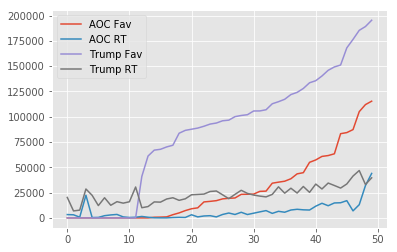

In [34]:
combined.plot()

### Exercise


Retreive the last 50 tweets with the hashtag #datavis in the SLC area, print the text and the username.